# Homework 3 — Neural models

In this homework, we will use *neural networks* as models for the IOB task that we worked on in the last assignment. In these models, the inference methods that worked well for FSTs are no longer usable, so we will need new decision agents. Equipped with these new tools, we will end the assignment in the construction of a transition-based neural dependency parser.

For now, let's start with the usual imports.

In [ ]:
num_threads = 1  # if you change this number you have to restart the notebook

# A hyperparameter for the size of all the hidden layers throughout the notebook.
# Note that it is uncommon to just use one number for everything and it can in fact
# complicate debugging -- but we do it for simplicity in this homework.
# Bonus pro tip: use prime numbers while prototyping, you can always see where your
# product come from!
HIDDEN_SIZE = 30

# set this before we import numpy
import os
os.environ['OMP_NUM_THREADS'] = str(num_threads)


import numpy as np
from scipy.misc import logsumexp
import sys
import re
from itertools import islice
from pprint import pprint
import math
import csv
from collections import namedtuple
import random

import scipy.optimize

import torch
from torch import nn, optim, Tensor, FloatTensor, LongTensor
import torch.nn.functional as F

torch.set_num_threads(num_threads)


from seq2class_homework1 import (
    TaskSetting,
    ProbabilityModel,
    BoltzmannModel,
    DecisionAgent,
    ViterbiAgent,
    BayesAgent,
    L2LogLikelihood,
    SGDTrainer
)

from seq2class_homework2 import (
    IobTask0,
    Integerizer,
    F1
)

Data_type = namedtuple('Data', ['xx', 'oo', 'yy'])

# data loading for the IOB task
def iterate_data(filename='train', *, max_examples=None):
    file = open(f'iob/{filename}.tsv')
    for n, row in enumerate(csv.DictReader(file, delimiter='\t')):
        if max_examples and n >= max_examples:
            break
        yield Data_type(
            xx=tuple(row['xx'].split()),
            oo=None,  # we are not dealing with partial observations in this homework
            yy=tuple(row['yy'].split()) if 'yy' in row else None,
        )

        
# data loading for the parsing task
Parse_Data_type = namedtuple('ParseData', ['xx', 'tree'])
def iterate_trees(filename='train', *, max_examples=None):
    file = open(f'trees/{filename}.tsv')
    for n, row in enumerate(csv.DictReader(file, delimiter='\t')):
        if max_examples and n >= max_examples:
            break
        yield Parse_Data_type(
            xx=tuple(row['xx'].split(' ')),
            tree=tuple(map(int, row['tree'].split())),
        )
        

## PyTorch Basics

For this assignment we will be using [PyTorch](http://pytorch.org/) to build a neural transition-based parser.  We will build up to writing a full parser by first constructing a neural representation of our words from the character sequence of each word.  We will then use this character representation to train a neural IOB tagger and eventually our neural parser.

Here are some useful pointers to the PyTorch docs:

#### Documentation links:
1. [Torch general documentation](http://pytorch.org/docs/stable/torch.html)
2. [Torch neural network layers](http://pytorch.org/docs/stable/nn.html)

#### Neural network layers that we will use through this assignment
| Neural Layer | Use |
|---|---|
| [nn.Linear](http://pytorch.org/docs/master/nn.html#torch.nn.Linear) | A single feed forward linear layer with bias. |
| [nn.LSTMCell](http://pytorch.org/docs/master/nn.html#torch.nn.LSTMCell) | Implements a single step of an LSTM returning the new hidden and cell states. |
| [nn.Embedding](http://pytorch.org/docs/master/nn.html#torch.nn.Embedding) | Holds an embedding matrix for tokens indexed by an integer array. |
| [nn.Parameter](http://pytorch.org/docs/master/nn.html#torch.nn.Parameter) | Holds a raw tensor but adds it to the list of parameters for training |

#### Useful PyTorch functions :
| Function | Use |
|---|---|
| [torch.cat](http://pytorch.org/docs/stable/torch.html#torch.cat) | concatenate tensors along a given dimension |
| [torch.stack](http://pytorch.org/docs/stable/torch.html#torch.stack) | adds a new dimension when combing tensors |
| [torch.tanh](http://pytorch.org/docs/stable/torch.html#torch.tanh) | Hyperbolic tangent function (non-linearity) |
| [torch.softmax](http://pytorch.org/docs/stable/torch.html#torch.softmax) | Compute the softmax over a tensor |
| [torch.zeros](http://pytorch.org/docs/stable/torch.html#torch.zeros) | Returns a new tensor filled with zeros |
| [torch.rand](http://pytorch.org/docs/stable/torch.html#torch.rand) | Returns a new tensor filled with random values in the $[0, 1)$ interval |

# Part 1: Backpropagating through Matrices and Checking your Answer

Backward-mode automatic differentiation a.k.a. backpropagation is the algorithmic workhorse of 
deep learning. It fuses the [chain rule](https://en.wikipedia.org/wiki/Chain_rule), taken from calculus, and [memoization](https://en.wikipedia.org/wiki/Memoization), a technique from algorithms. 

Let’s first talk about the calculus. As students, you likely spent a lot of time manually taking derivatives with respect to real scalars in univariate calculus and with respect to real vectors in multi-variate calculus. If you took complex analysis, you may have even taken derivatives with respect to complex-valued quantities. But what of matrices? In deep learning, we are often interested in the derivative with respect to a real matrix. For instance, consider this simple log-linear model for binary classification: $p(y \mid x) = \textit{sigmoid}(W x)$, where $x \in \mathbb{R}^d$ is the input to the model, $W \in \mathbb{R}^{2 \times d}$ is a matrix of parameters. Typically, we choose $W$ so as to minimize the loss ${\cal L}(W) = -\sum_{i=1}^n \log p(y^{(i)} \mid x^{(i)})$, perhaps with a regularization terms, which we would achieve algorithmically by following the gradient $\frac{\partial L}{\partial W}$ until we reach a (local) optimum. 

To get you comfortable with taking derivatives with respect to matrices, let's go through a few theoretical exercises to get you warmed up. Note that the general strategy will be to break down the function into a series of sums, using the definition of the matrix operations, and, then, apply standard techniques from univariate calculus.

### Question 1.1: The Derivative of Latent Semantic Analysis (LSA)

Suppose you have a large matrix $X \in \mathbb{R}^{N \times M}$ and you would like to approximately factorize it.  This *matrix factorization* problem pops up in *latent semantic analysis* (LSA, an old pre-neural technique to get word embeddings), where $X_{ij}$ is the number of times word $i$ appears in context $j$.  In this question, however, we will generalize by allowing the entries of $X$ to be real numbers rather than counts.

Let us try to express $X \approx AB$ where $A \in \mathbb{R}^{N \times K}$ and $B \in \mathbb{R}^{K \times M}$.  Note that $\textit{rank}(AB) \leq K$. By setting $K$ to a small value, we can ensure that this rank is less than the original $\textit{rank}(X)$, which may be as large as $\min(N,M)$.  Thus, we regard $AB$ as a low-rank approximation to $X$.

Specifically, we will minimize ${\cal L}_\textit{lsa}(A, B) = \frac{1}{2}||X - AB||^2_F$, where $||\cdot||_F$ denotes the [Frobenius norm](http://mathworld.wolfram.com/FrobeniusNorm.html) of a matrix.

While we can globally minimize this particular objective with use of the Singular Value Decomposition, one may also use gradient descent, albeit without the globally optimal guarantee. So, for practice, let's figure out the gradient of the objective with respect to the parameters—namely the elements of $A$ and $B$.

#### The Gradient of Matrix Multiplication

More specifically, the goal is to compute $\frac{\partial {\cal L}_\textit{lsa}}{\partial A}$ and $\frac{\partial {\cal L}_\textit{lsa}}{\partial B}$. But what does that even mean when $A$ and $B$ are matrices?  We'd better try temporarily eliminating the matrix notation and just using good old single-variable calculus:
$$ {\cal L}_\textit{lsa}(A, B) = \frac{1}{2}||X - AB||^2_F = \frac{1}{2}\sum_{i'=1}^N \sum_{j'=1}^M (X_{i'j'} - \sum_{k'=1}^K A_{i'k'} B_{k'j'})^2$$

Now for any fixed $i,j,k$, you should be able to write down formulas for both $\frac{\partial {\cal L}_\textit{lsa}}{\partial A_{ik}}$ and $\frac{\partial {\cal L}_\textit{lsa}}{\partial B_{kj}}$.  (We used $i',j',k'$ in the objective function above so that you could keep the summation indices separate from the indices of the specific fixed variable that you are differentiating with respect to.)

$$
\begin{align*}
\frac{\partial {\cal L}_\textit{lsa}}{\partial A_{ik}} &= \color{red}{\text{FILL IN}} \\
\frac{\partial {\cal L}_\textit{lsa}}{\partial B_{kj}} &= \color{red}{\text{FILL IN}} \\
\end{align*}
$$


Congratulations: you have just written formulas for computing the $NK + KM$ different partial derivatives.  It's convenient to store all those real numbers in a pair of matrices, which are what we call $\frac{\partial {\cal L}_\textit{lsa}}{\partial A} \in \mathbb{R}^{N \times K}$ and $\frac{\partial {\cal L}_\textit{lsa}}{\partial B} \in \mathbb{R}^{K \times M}$.  

Can you write formulas that compute those matrices using only matrix operations (which are fast in numpy and PyTorch)?  Check: the correct answer $\textit{only}$ requires multiplication, subtraction, and transposition on matrices.

$$
\begin{align*}
\frac{\partial {\cal L}_\textit{lsa}}{\partial A} &= \color{red}{\text{FILL IN}} \\
\frac{\partial {\cal L}_\textit{lsa}}{\partial B} &= \color{red}{\text{FILL IN}} \\
\end{align*}
$$


### Automatic Differentiation

Recall that PyTorch will automatically compute gradients for you using [reverse-mode automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation#Reverse_accumulation). This algorithm was discussed and demoed in class. See it in action below.

In [ ]:
# variables
n = 5; k = 2
# random initialization of the parameters
A = torch.randn(n, k, requires_grad=True)
B = torch.randn(k, n, requires_grad=True)
# random positive matrix to factorize
X = torch.exp(torch.randn(n, n, requires_grad=True))

In [ ]:
def Llsa(A, B):
    """
    Loss function for matrix factorization
    """
    C = torch.mm(A, B)
    loss = 0.5 * ((X-C)**2).sum()
    return loss

In [ ]:
A.grad = None
B.grad = None
loss = Llsa(A, B)
loss.backward()
dLlsa_dA_auto = A.grad.numpy()
dLlsa_dB_auto = B.grad.numpy()

### Now, fill in the following functions with your answer from above


In [ ]:
def dLlsa_dA(A, B):
    """ Computes the derivative of L with respect to the matrix A"""
    ### STUDENTS START
    raise NotImplementedError()  # REPLACE ME
    ### STUDENTS END


In [ ]:
def dLlsa_dB(A, B):
    """ Computes thederivative of L with respect to the matrix B """
    ### STUDENTS START
    raise NotImplementedError()  # REPLACE ME
    ### STUDENTS END


In [ ]:
# the following two assert statements should pass if you did it right :-)
assert np.allclose(dLlsa_dA_auto, (dLlsa_dA(A, B)), atol=1e-2)
assert np.allclose(dLlsa_dB_auto, (dLlsa_dB(A, B)), atol=1e-2)

### Question 1.2: The Derivative of Skip-Gram

Again, let $X \in \mathbb{R}^{N \times M}$, $A \in \mathbb{R}^{N \times K}$ and $B \in \mathbb{R}^{K \times M}$ be real-valued matrices. We will
consider the objective function 

${\cal L}_{\textit{skipgram}}(A, B) = \sum_{i=1}^N \sum_{j=1}^M X_{ij} \log p(i \mid j ; A, B)$, 

whose derivative you will find with respect to both $A$ and $B$. We define the following 

$\log p(i \mid j; A, B) = \log \textit{softmax}((AB)_{:j})_{i} = \log \frac{\exp\,(AB)_{ij}}{\sum_{i'=1}^N \exp\, (AB)_{i'j}} = (AB)_{ij} - \log \sum_{i'=1}^N \exp\, (AB)_{i'j}$

Recall from class that this objective is called the [skip-gram](https://en.wikipedia.org/wiki/Word2vec) objective, which is what word2vec is trying to optimize for.
Again, the basic strategy for finding the derivatives is the same---break the objective down into summands. Compute:

$$
\begin{align*}
\frac{\partial {\cal L}_\textit{skipgram}}{\partial A} &= \color{red}{\text{FILL IN}} \\
\frac{\partial {\cal L}_\textit{skipgram}}{\partial B} &= \color{red}{\text{FILL IN}} \\
\end{align*}
$$

Let's implement this again (we'll just reuse the same matrices, thus setting $M=N$):

In [ ]:
def Lskipgram(A, B):
    logit = torch.mm(A, B)
    return (X * F.log_softmax(logit, dim=0)).sum()

In [ ]:
# Renew the computation graph -- by simply starting from scratch.
A = torch.randn(n, k, requires_grad=True)
B = torch.randn(k, n, requires_grad=True)
X = torch.exp(torch.randn(n, n, requires_grad=True))
# HINT: these two matrices (and their names) should help you see relation
# between the gradient of skip-gram's matrices and those of the log-linear model
# you saw in NLP assignment 3. 
logit = torch.mm(A, B)
P = F.softmax(logit, dim=0)
X_expected = torch.mm(P, torch.diag(X.sum(0).squeeze(0)))


Now, fill in the following functions:


In [ ]:
def dLskipgram_dA(A, B):
    """ Computes the derivative of L with respect to the matrix A"""
    ### STUDENTS START
    raise NotImplementedError()  # REPLACE ME
    ### STUDENTS END


In [ ]:
def dLskipgram_dB(A, B):
    """ Computes thederivative of L with respect to the matrix B """
    ### STUDENTS START
    raise NotImplementedError()  # REPLACE ME
    ### STUDENTS END


In [ ]:
# automatic differentiation again
loss = Lskipgram(A, B)
loss.backward()
dLskipgram_dA_auto = A.grad.data.numpy()
dLskipgram_dB_auto = B.grad.data.numpy()

In [ ]:
# the following two assert statements should pass if you did it right :-)
assert np.allclose(dLskipgram_dA_auto, (dLskipgram_dA(A, B)), atol=1e-2)
assert np.allclose(dLskipgram_dB_auto, (dLskipgram_dB(A, B)), atol=1e-2)

### Question 1.3: The finite-difference check

Let’s suppose, for a second, we didn’t have an automatic-differentiation toolkit available. Is there, perhaps, another way that we can use a computer to compute the gradient? The most common numerical method at our disposal is called the finite-difference check.

#### Background
Consider a smooth function $f : \mathbb{R}\rightarrow \mathbb{R}$. Recall from calculus,
that for $x, \varepsilon \in \mathbb{R}$, the first-order Taylor approximation of $f$ may be written
as

$
f(x + \varepsilon) = f(x) + \varepsilon f'(x) + o(|\varepsilon|^2)
$

If little-o notation is unfamiliar to you, just interpret $o(|\varepsilon|^2)$
as the order of magnitude of the error term. More often, this formula is written as,

$
    f'(x) \approx  \frac{f(x + \varepsilon) - f(x)}{\varepsilon}
$

The equation above is termed the **forward difference** in the numerical analysis literature.  
Note that in the limit as $\varepsilon \rightarrow 0$, the equation is exact. Indeed,
you may recognize this as the definition of the derivative. We may also consider the
**backward difference**

$
    f'(x) \approx  \frac{f(x) - f(x - \varepsilon)}{\varepsilon}
$

which follows were we to replace $(x+\varepsilon)$ with $(x-\varepsilon)$ in the derivation
of the forward difference from the Taylor approximation. Averaging the forward and backward difference,
yields the **central difference**.

$
f'(x) \approx \frac{f(x + \varepsilon) - f(x - \varepsilon)}{2\varepsilon}
$



### Operationalizing the finite-difference check

Now, let's operationalize the finite-difference check. Given a function $f(x) = \sin(x^2) + 10$, we are going to ask you to implement the finite-difference method and compare the output to a derivative you compute analytically: *checking* the correctness of derivative and gradient computations is the primary use case of the finite-difference method, after all.


In [ ]:
def f(x):
    """ a fun function"""
    return np.sin(x**2) + 10

In [ ]:
def df(x):
    """ compute the derivative of f symbolically"""
    ### STUDENTS START
    raise NotImplementedError()  # REPLACE ME
    ### STUDENTS END


In [ ]:
def df_fd(x, eps=1e-5):
    """ compute the derivative of f using the finite-difference check"""
    ### STUDENTS START
    raise NotImplementedError()  # REPLACE ME
    ### STUDENTS END


In [ ]:
# if you have done it right, these two checks should pass
assert np.allclose(df(5.0), df_fd(5.0), atol=1e-2)
assert np.allclose(df(-2.0), df_fd(-2.0), atol=1e-2)

### Question 1.4: Extension to functions of many variables

In the land of machine learning, we are generally interested in computing the partial derivatives of a function
of many variables: $f : \mathbb{R}^n \rightarrow \mathbb{R}$. (The vector of partial derivatives is called the gradient.) How do we extend the finite-difference check to this case? As it turns out, it's quite trivial. Say we have a function $f(x_1, \ldots, x_n)$: to compute $\nabla_{\mathbf{x}} f$, we simply perform the univariate finite-difference check on each component of the input individually. Write a function to do this for each of the parameters $A \in \mathbb{R}^{N \times K}$ and $B \in \mathbb{R}^{K \times M}$. 


In [ ]:
def finite_difference(Y, f, eps=1e-2):
    """ compute the finite-difference approximation for the function f"""
    # populate this numpy matrix
    dY = np.zeros((Y.size(0), Y.size(1)))
    ### STUDENTS START
    raise NotImplementedError()  # REPLACE ME
    ### STUDENTS END
    return dY

In [ ]:
# the following two assert statements should pass if you did it right :-)
assert np.allclose(dLskipgram_dA_auto, finite_difference(A, lambda Y: Lskipgram(Y, B)), atol=1e-2)
assert np.allclose(dLskipgram_dB_auto, finite_difference(B, lambda Y: Lskipgram(A, Y)), atol=1e-2)

### Question 1.5: Runtime of the Finite-Difference Check

Finally, let's analyze the runtime of the finite-difference check and compare it to the runtime of automatic differentiation.

Let $f\colon \mathbb{R}^n \rightarrow \mathbb{R}$ be a differentiable function that can be computed in $\textrm{runtime}(f)$. In big-$O$ notation, we would write that we can compute $f$ in $O(\textrm{runtime}(f))$. 

As a function of $\textrm{runtime}(f)$ and $n$, give (in big-$O$ notation) the following two runtimes:

$$
\begin{align*}
\text{runtime of backward-mode automatic differentiation for all $n$ parameters}  &= \color{red}{\text{FILL IN}} \\
\text{runtime of the finite-difference check for all $n$ parameters} &= \color{red}{\text{FILL IN}} \\
\end{align*}
$$

What does this analysis ever tell you about the practicality of the finite-difference method for computing the derivatives within an optimization routine for neural networks?


# Part 2: Embedding words using their character representation

As a warm-up, we will embed actual words using recurrent neural networks, specifically using long short-term memory (LSTM). We would like for each word to be represented as a single fixed sized vector, this will allow us to more easily feed into later stages of our training pipe line.  We are going to accomplish this using a character level LSTM over the characters in the word.

For each word in the sequence `xx`, we are going to split it into characters and represent each character an integer.  To pass this representation into the LSTM, we will use a one-hot encoding, meaning at each step we will apply the LSTM to a tensor that contains a single 1 value and zeros otherwise.


### PyTorch Basics

For this assignment we will be using [PyTorch](http://pytorch.org/) to build a neural transition-based parser.  We will build up to writing a full parser by first constructing a neural representation of our words from the character sequence of each word.  We will then use this character representation to train a neural IOB tagger and eventually our neural parser.

Here are some useful pointers to the PyTorch docs:

#### Documentation links:
1. [Torch general documentation](http://pytorch.org/docs/stable/torch.html)
2. [Torch neural network layers](http://pytorch.org/docs/stable/nn.html)

#### Neural network layers that we will use through this assignment
| Neural Layer | Use |
|---|---|
| [nn.Linear](http://pytorch.org/docs/master/nn.html#torch.nn.Linear) | A single feed forward linear layer with bias. |
| [nn.LSTMCell](http://pytorch.org/docs/master/nn.html#torch.nn.LSTMCell) | Implements a single step of an LSTM returning the new hidden and cell states. |
| [nn.Embedding](http://pytorch.org/docs/master/nn.html#torch.nn.Embedding) | Holds an embedding matrix for tokens indexed by an integer array. |
| [nn.Parameter](http://pytorch.org/docs/master/nn.html#torch.nn.Parameter) | Holds a raw tensor but adds it to the list of parameters for training |

#### Useful PyTorch functions :
| Function | Use |
|---|---|
| [torch.cat](http://pytorch.org/docs/stable/torch.html#torch.cat) | concatenate tensors along a given dimension |
| [torch.stack](http://pytorch.org/docs/stable/torch.html#torch.stack) | adds a new dimension when combing tensors |
| [torch.tanh](http://pytorch.org/docs/stable/torch.html#torch.tanh) | Hyperbolic tangent function (non-linearity) |
| [torch.softmax](http://pytorch.org/docs/stable/torch.html#torch.softmax) | Compute the softmax over a tensor |
| [torch.zeros](http://pytorch.org/docs/stable/torch.html#torch.zeros) | Returns a new tensor filled with zeros |
| [torch.rand](http://pytorch.org/docs/stable/torch.html#torch.rand) | Returns a new tensor filled with random values in the $[0, 1)$ interval |

You should probably also familiarize yourself with different ways to inspect tensors, querying their `shape`, `size()`, `dim`, and the (still fairly new) zero-dimensional tensors, who encapsulate single scalars, acessible via `item()`.

### A simple implementation

Look at the code below.

In PyTorch, neural modules are often encapsulated into classes that inherit from `nn.Module` -- this gives them useful features like keeping track of all the parameters that we want to learn.

More specifically, see how the `CharacterLSTMPreprocessModule` has two *parameters*: an `nn.LSTMCell` and an initial vector.
PyTorch modules are executed by calling the `forward()` method.
Here, we loop over the characters in the input word, encode each as a [one-hot vector](https://en.wikipedia.org/wiki/One-hot), and, then, calls ``self.character_lstm``. In short, you are unfolding the LSTM over the character stream. The sanity checks below should help guide you. You will implement similar methods in the next questions.

You will notice that we have a first dimension of size 1 on both the one-hot vector and the hidden states. This dimension is usually used for *batching*, i.e., processing multiple data points at the same time. We will for now limit ourselves to just a single data point, so this dimension is of size 1 (omitting it makes some PyTorch methods fail).

(If you are interested, spend a few minutes thinking about possible complications here! Batching variable-length sequences is a little tricky and all frameworks have come up with different solutions for them.)

In [ ]:
class CharacterLSTMPreprocessModule(nn.Module):
    """
    CharacterLSTMPreprocessModule takes an `xx` input string, and maps it to an embedding tensor using a
    character level LSTM over each input word.  We 
    """
    
    def __init__(self, integerizer):
        super().__init__()
        
        # string integerizer from homework 2
        self.integerizer = integerizer
        
        # the parameters and submodules for this module
        self.character_lstm = nn.LSTMCell(len(integerizer), HIDDEN_SIZE)
        self.character_lstm_init = nn.Parameter(torch.rand(1, HIDDEN_SIZE))
        
    def forward(self, *, xx):
        """
        Preprocess the input sequence xx of words into a sequence of word embeddings.
        """
        output = []
        # For each word:
        for x in xx:
            # initalize the hidden state of the LSTM
            cx = self.character_lstm_init
            hx = torch.tanh(cx)
            # Now loop over each character in the word:
            for c in x:
                # One-hot encoding
                i = torch.zeros(1, len(self.integerizer))
                i[0, self.integerizer.index(c)] = 1
                # Run the LSTM
                hx, cx = self.character_lstm(i, (hx, cx))
            output.append(hx)
        # Stack all gained word embeddings into a single tensor.
        return torch.stack(output, dim=1)

### Simple tests

In [ ]:
# Let's test the character LSTM module
dutch_characters = set(c for d in iterate_data('train') for c in ' '.join(d.xx))
dutch_character_integerizer = Integerizer(tuple(dutch_characters))

dutch_preprocess = CharacterLSTMPreprocessModule(dutch_character_integerizer)

# Since we inherited from nn.Module, we can now see all parameters automatically:
print('Parameters in model:\n\t'+ '\n\t'.join(
    list(name for name, value in dutch_preprocess.named_parameters())))

# Get a first example out of the dutch training data and process it:
xx, oo, yy = next(iterate_data('train-small'))
# This will call the forward() method we defined above
xx_processed = dutch_preprocess(xx=xx)

# Check that the output is a PyTorch tensor and that the size has
# a 1 in the first dimention to represent the mini-batch
# the length of the input sentence for the second dimention
# the HIDDEN_SIZE to represent the size of the hidden state that we are using to represent words
assert xx_processed.shape == (1, len(xx), HIDDEN_SIZE)

# Look at the tensors:
xx_processed

You can see that this is a tensor with three dimensions of size 1, 3, and 30 -- and you can already see that PyTorch also stored a function pointer to calculate the gradients. So let's make use of that!

### Basic training task for `CharacterLSTMPreprocessModule`

The above only checked that the output of `CharacterLSTMPreprocessModule` was the correct shape, however to check that the model is actually capable of *learning* a function, we need to set up a simple task.

Below, we have defined `SimpleWordClassification` which takes the embedding of a word and attempts to predict if the word contains the letter 'e'.
This model classifies a word by performing $p_i = \sigma(W e(\text{word}_i) + b)$, where it applies a linear transform of $Wx + b$ to the output of our embedding layer $e(\cdot)$ and then a sigmoid function to map to $[0, 1]$.

To train this model, we need to define a *training loss*.  For this simple model we define the training loss as the squared difference between the correct label and the predicted label $\sum_i (l_i - p_i)^2$.  To train the model, we need to take the derivative of *all* the parameters with respect to the scalar that represents the training loss.  This is done for us *automatically* when calling PyTorch's `.backward()` method on the loss tensor.

For this simple model, we are choosing to train it using just standard [SGD](http://pytorch.org/docs/master/optim.html#torch.optim.SGD) like in the previous homeworks. However, this function is again provided for by PyTorch.  Using `torch.optim.SGD`, we take a list of all the parameters in the model (which we can get as `model.parameters()`) and a learning rate.  Once we have computed the gradients (as described above), `optimizer.step()` to take a single step in the direction of the gradient.  Note, that the optimizers in PyTorch are always seeking to *minimize* the loss (so if you want to maximize a value do `(-reward).backward()`).

If you have correctly implemented `CharacterLSTMPreprocessModule` you should see that large difference between the positive and negative training examples below.

In [ ]:
class SimpleWordClassification(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.word_embedding = CharacterLSTMPreprocessModule(dutch_character_integerizer)
        self.word_classifier = nn.Linear(HIDDEN_SIZE, 1)
        
    def forward(self, xx):
        embedding = self.word_embedding(xx=xx)  # this will call self.word_embedding.forward(....)
        return torch.sigmoid(self.word_classifier(embedding))
    
dutch_words = set(x for d in iterate_data('train') for x in d.xx)
# split the words such that there is some classification boundary that we can learn
# here we are using words that contain the letter 'e'
positive_words = set(word for word in dutch_words if 'e' in word)
negative_words = dutch_words - positive_words

simple_classifier = SimpleWordClassification()

optimizer = torch.optim.SGD(simple_classifier.parameters(), lr=.05)

# Let's train for 3 epochs
for _ in range(3):
    # In each epoch iterate over all words
    for word in list(dutch_words):
        l_i = int(word in positive_words)
        p_i = simple_classifier([word])
        
        # squared error -- a most simple loss
        loss = (l_i - p_i)**2
        
        # compute the gradient of all parameters with respect to the loss tensor
        # This will traverse the computation graph backwards from the `loss` node,
        # for each node computing the gradient and storing it in this node's `.grad`.
        loss.backward()

        # make the optimization method take a single step
        # This essentially calls `parameter -= optimizer.lr * parameter.grad`
        # for each parameter that it got passed above (simple_classifier.parameters())
        # Go ahead and try doing things manually like that yourself!
        optimizer.step()

        # As the gradients are accumulated into `.grad`, we need to zero it before the
        # next update -- or PyTorch will just accumulate the next gradient on top of the old one
        #
        # (Keeping .step() seperate from .zero_grad() is useful in the case that 
        # there are multiple operations which will use the same gradients.)
        optimizer.zero_grad()
    
    
    # quickly test how well the model is doing on the *training* data
    # You should know by now that this merely tests if we can *(over)fit*,
    # not if we truly "learn", that is, generalize to new data!
    pos_avg = simple_classifier(list(positive_words)).mean().item()
    neg_avg = simple_classifier(list(negative_words)).mean().item()
    
    print(f"Avg pos/neg ex prob: {pos_avg:.5f} / {neg_avg:.5f}")

Defining the loss as the squared distance $\sum_i (l_i - p_i)^2$ should have felt silly to you -- why not instead maximize likelihood like we usually do with probabilities?

Specifically, let's minimize the *negative log-likelihood* (NLL). What objective is that here? Use the same notation ($l_i$ and $p_i$) as above:

$$\text{minimize}\; \color{red}{\text{FILL IN}}$$

Try to replace the squared loss above with the NLL loss! How does the performance compare?

$$\color{red}{\text{FILL IN}}$$

Note that if you run into issues with NaNs, there is most likely an issue in your formula, perhaps a missing sign (this little exercise there is no need to use numerically stable functions like `log1p(x)` instead of `log(1+x)`).
But why should you still be a little worried about this code?

Even and perhaps especially in neural times we still much prefer to work with log-probabilities throughout. This then also means using functions like `logsigmoid` instead of `sigmoid` and `log_softmax` instead of `softmax`.
The entire topic of numerical (in-)stability is very interesting and annoying at the same time, but the guidelines are the same ones that you know: beware of numbers close to 0, especially whenever they interact with numbers that are not.

We'll pretend that everything is fine and keep going on with this assignment, though, as later we will naturally end up working with log-probabilities. Still, it will be useful to read a little but about `log1p()`, `expm1()`, and `log_softmax()` as you will likely end up wanting to use them for many calculations when training neural models in a stable way.

## Part 3: Transition-based Tagging

We will now learn about a very popular way to perform structured prediction: transition-based models.

You will remember that in HW1, we explicitly enumerated all possible outputs $\mathbf y$ to score them individually and then select the best structure (or sequence) from the set of all $\mathbf y$'s.
In HW2, we circumvented the need for enumeration by using dynamic programming, letting OpenFST do the heavy lifting for us.
Since in this homework we want more complicated scoring functions that aren't as nicely decomposable, we will need a new way to build up structures that doesn't require exhaustive enumeration.

Transition-based models reduce the search for a structure to a sequence of individual predictions that togther fully describe the structure. For example, let the structure be an IOB tag sequence. Then a good way to decompose the entire sequence into a sequence of "transitions" or "actions" is to have every one of these actions be the prediction of an individual tag: first predict the first one, then the second one, and so on until we've reached the end of our input.

The perhaps less obvious question is: what about state? Transition systems always maintain some state, usually containing a description of things that have been "assembled" already (in our case, the sequence of all already predicted tags), but later we will also have this state contain the "buffer" of things yet to process. But let's start simple.

We will need to define a new kind of `TaskSetting`, one that allows for such a state to be used in proposing new individual actions (i.e., what `iterate_y` does), as depending on the state, not all actions may be available (for example, if our last action was a `O` tag, we cannot propose an `I` tag in the IOB scheme).

Below, you can see the base class for these transition tasks.
Note that we added a new function `iterate_a` that we will use instead of the old `iterate_y` to help make the distinction clear -- it takes an arbitrary `state`, not just a strictly sequential `yy_prefix`, even though that will be the easiest and most obvious use case.

(Maybe `StatefulTaskSetting` should be the standard `TaskSetting` and we should have introduced it as such in Homework 1? You tell us! :) )

In [ ]:
class StatefulTaskSetting(TaskSetting):
    def initial_taskstate(self, *, xx):
        """
        The initial state for an input `xx`. Needs to be overriden.
        """
        raise NotImplementedError()
        
    def next_taskstate(self, *, xx, a, taskstate):
        """
        Returns the state that results from the execution of action `a` in state `taskstate`.
        """
        raise NotImplementedError()
    
    def iterate_a_s(self, *, xx, oo=None, taskstate):
        """
        This method can iterate all possible actions given a state of the model.
        It returns a tuple with both the action and the new state that would result from taking it.
        
        The default implementation calls the task's iterate_y with state as the yy_prefix
        for easier compatibility with our old `TaskSetting`.
        
        Remember that this method ought to yield `None` (as one possible "action")
        when the given `taskstate` permits stopping.
        """
        for a in self.iterate_y(xx=xx, oo=oo, yy_prefix=taskstate):
            yield (a, self.next_taskstate(xx=xx, a=a, taskstate=taskstate))
    
    def iterate_a(self, *, xx, oo=None, taskstate):
        """
        Convenience method to only get action proposals without resulting states.
        """
        for a, _ in self.iterate_a_s(xx=xx, oo=oo, taskstate=taskstate):
            yield a
        
    def iterate_aa(self, *, xx, oo=None):
        """
        Returns an iterator over plans that are allowed for input `xx`.
        """
        def _finish_prefix(aa_prefix, taskstate):
            """Iterate over just those `aa` sequences starting with `aa_prefix`."""
            for a, s in self.iterate_a_s(xx=xx, oo=oo, taskstate=taskstate):
                if a is None:
                    yield aa_prefix
                else:
                    yield from _finish_prefix(aa_prefix + (a,), s)
        yield from _finish_prefix(tuple(), self.initial_taskstate(xx=xx))
        

With this new scaffolding, we can mostly reuse the old `IobTask0` from HW2:

In [ ]:
class IobStatefulTask(StatefulTaskSetting, IobTask0):
    def initial_taskstate(self, *, xx):
        """
        Since for the IOB task we want to iteratively construct the tag
        sequence, start with an empty sequence.
        """
        return tuple()

    def next_taskstate(self, *, xx, a, taskstate):
        """
        Since for the IOB task our tags are our actions, just add them to the sequence.
        """
        return taskstate + (a,)

iob_task = IobStatefulTask()

# Convince ourselves that everything still works like before:
list(iob_task.iterate_aa(xx=["word", "word", "word"]))

## IOB Transition Model

Now let's talk about the model we want to use. It will have a *backwards LSTM* which is encoding the words we have *yet* to see in the sentence, as well as a forward LSTM which encodes every word that we already saw -- and the IOB tag that we chose to assign to that word!

<img width=450px src='images/iob-lstm.png'>

In the above figure, we just tagged the third word $x_3$ with tag $y_3$. Each circle represents a step of the LSTM where we are passing the hidden state to the next time step.  As we consume more tokens of the input $\mathbf x$, we will *pop* off computed vectors of the backwards LSTM (on the right), and we will compute a new representation with the forward LSTM to continue to the next tag.
You can look at the [decision agent](#DecisionAgent) below to see exactly how we are going to use the transition model before you attempt to implement it.

(Don't confuse this model with a simpler model, in which we would take forward+backward-LSTM approach, but predict all tags in isolation. Our model is strictly more powerful as past tags influence future tags -- but that makes decoding a little bit more challenging.)

Since we want to keep the TaskSetting and Model separate and make this neural model fit into the hierarchy we built up in HW1, it is now time to inherit from `ProbabilityModel` (specifically we will inherit from `BoltzmannModel` to show that we can still use the slow brute-force ideas from HW1).

At this point we realize that we no will probably want to share a *computational* "state" between different sequences (namely those with equal yy_prefixes) -- we therefore introduce a new class that will be made for incremental computations. Its state we will call *model state* to not confuse it with the task state that we defined earlier.

In [ ]:
class IncrementalScoringModel(BoltzmannModel):

    def initial_modelstate(self, *, xx):
        """
        Return the initial model state object for this model given `xx`. Default is None.
        """
        return None
    
    def score_a_s(self, *, xx, a, taskstate, modelstate):
        """
        Returns a tuple with:
        1) the score of an action `a` for input example `xx` when the task state
             is `taskstate` and the model state in `modelstate` and
        2) the new modelstate object if this action was executed.
        """
        raise NotImplementedError()
    
    def score_aa(self, *, xx, aa):
        """
        Will just unroll the entire computation for a single `aa`.
        Note that we will not use this function -- it just serves as an illustration
        of what's possible using our class design.
        """
        taskstate = self.task.initial_taskstate(xx=xx)
        modelstate = self.initial_modelstate(xx=xx)
        sum_score = 0
        for a in aa:
            score, modelstate = self.score_a_s(xx=xx, a=a, taskstate=taskstate, modelstate=modelstate)
            taskstate = self.task.next_taskstate(xx=xx, a=a, taskstate=taskstate)
            sum_score += score
        return sum_score
    
    def score(self, *, xx, yy):
        """
        For compatibility with the BoltzmannModel methods, define this as a wrapper
        around score_aa that pretends aa == yy. We will not use this method for our tasks,
        but it serves as a neat visualization that the brute-force techniques from the
        HW1 Boltzmann model still work.
        """
        return self.score_aa(xx=xx, aa=yy).item()

Let's now implement our neural IOB tagging model to follow this structure:

In [ ]:
class TaggingTransitionModel(IncrementalScoringModel, nn.Module):

    def __init__(self, task, preprocessor):
        # Always initialize the PyTorch module first, so the registration hooks work!
        nn.Module.__init__(self)
        super().__init__(task)
        self.preprocessor = preprocessor

    def initialize_params(self):
        """
        This method from our `ProbabilityModel` now initializes neural nets.
        """
        # The LSTMs that encode the input sequence.
        # The input for the forward state should be the word embedding of x_i
        # and, one-hot encoded, the tag y_i we are considering for it.
        self.forward_lstm = nn.LSTMCell(HIDDEN_SIZE + len(self.task.Y_alphabet), HIDDEN_SIZE)
        self.backward_lstm = nn.LSTMCell(HIDDEN_SIZE, HIDDEN_SIZE)
        
        # Score the current proposal given the hidden forward and backward LSTMs state.
        self.score_function = nn.Linear(HIDDEN_SIZE*2, 1)
        
        # The initial hidden states, represents the EOS and BOS for the respective LSTMs
        self.forward_lstm_init = nn.Parameter(torch.rand(1, HIDDEN_SIZE))
        self.backward_lstm_init = nn.Parameter(torch.rand(1, HIDDEN_SIZE))

    def initial_modelstate(self, *, xx):
        """
        Return the initial modelstate object for this model: the word embeddings,
        the lookahead (i.e., backwards) LSTM states, and the initial state for the
        forward LSTM.
        """
        # Run the preprocessor to generate a representation for each token in the input xx.
        # We will pop the elements off this list as we read and use them during prediction.
        xx_embedding = self.preprocessor(xx=xx)
        
        # Initialize the backward LSTM
        cx = self.backward_lstm_init
        hx = torch.tanh(cx)
        lookahead = [hx]
        
        # Run backwards through the word of the sentence
        for i in range(xx_embedding.shape[1]-1, -1, -1):
            # Compute next representation and save it
            hx, cx = self.backward_lstm(xx_embedding[:,i], (hx, cx))
            lookahead.append(hx)
            
        # Initialize the forward LSTM
        cx = self.forward_lstm_init
        hx = torch.tanh(cx)
        
        return xx_embedding, tuple(lookahead), (hx, cx)
    
    def score_a_s(self, *, xx, a, taskstate, modelstate):
        """
        Returns the unnormalized log-probability of an action `a` for input example `xx`
        when the task state is in `state` and the model state in `modelstate`.
        
        Note that if we were to follow PyTorch conventions, we would likely call this
        method `forward()`, so it would be executed whenever we "call the object".
        But we'll prefer to keep the names meaningful here.
        """
        # Easy access to the modelstate object
        xx_embedding, lookahead, (hx, cx) = modelstate
        
        # Get the representations for this timestep
        # Since we remove all previously used x tokens off the list xx_embedding,
        # the first element is the one we are interesting in now.
        x = xx_embedding[:, 0]  
        yi = torch.zeros(1, 3)
        yi[0, self.task.Y_alphabet.index(a)] = 1
        
        # Compute the new hidden states (hx, cx) of the forward LSTM and the score function
        ### STUDENTS START
        raise NotImplementedError()  # REPLACE ME
        ### STUDENTS END
        
        # Return score and the next modelstate
        assert score.dim() == 0, f"Score shape is {score.shape}, but should be {torch.tensor(0.0).shape}"
        return score, (xx_embedding, lookahead, (hx, cx))

If you implented it correctly, the score should be a 0-dimensional tensor (i.e., just a scalar).

Let us for a moment pretend that we wanted to build a simple locally normalized model. Then 

In [ ]:
iobtask = IobStatefulTask()
model = TaggingTransitionModel(iobtask, dutch_preprocess)

print("Assuming a global normalization scheme (i.e., use `BoltzmannModel`)")
Z = 0.0
for aa in iobtask.iterate_aa(xx=["word", "word"]):
    p = model.prob(xx=["word", "word"], yy=aa)
    Z += p
    print(aa, f"{p:.2f}")
print(f"Z = {Z.item():.3f}")
print("\n")

print("Assuming a local normalization scheme")
Z = 0.0
for aa in iobtask.iterate_aa(xx=["word", "word"]):
    xx=["word", "word"]
    taskstate = model.task.initial_taskstate(xx=xx)
    modelstate = model.initial_modelstate(xx=xx)
    log_p = 0
    if aa[-1] is None:
        aa = aa[:-1]
    for a_wanted in aa:
        scores = []
        for a_proposal, state_proposal in model.task.iterate_a_s(xx=xx, taskstate=taskstate):
            scores.append(model.score_a_s(xx=xx, a=a_proposal, taskstate=taskstate, modelstate=modelstate)[0])
        logZ = torch.logsumexp(torch.stack(scores), dim=-1)
        score_wanted, modelstate = model.score_a_s(xx=xx, a=a_wanted, taskstate=taskstate, modelstate=modelstate)
        taskstate = model.task.next_taskstate(xx=xx, a=a_wanted, taskstate=taskstate)
        log_p += score_wanted - logZ
    Z += log_p.exp()
    print(aa, f"{log_p.exp().item():.2f}")
print(f"Z = {Z.item():.3f}")

As expected, the probabilities of all these different paths seem to sum to one for both normalization schemes... and since we didn't start training yet, the roughly uniform results should not be so surprising... but wait: why are the first two more likely than the last two -- and why *only in the locally normalized model*?

$$\color{red}{\text{FILL IN}}$$

### Training a Transition Model

To train our transition model, we would ideally like to maximize the log probability of $P(\mathbf y \mid \mathbf x)$, however, we are unable to efficiently compute the normalizing function $Z(\mathbf x)$ as we do not have a dynamic program over the $\mathbf y$ strings and thus would require computing the exponentially sized $\mathcal{Y}$ set. (What we did earlier, where we called the BoltzmannModel methods is very much not feasible for bigger inputs -- try it!)

Instead, our first attempt will be to try to train our transition model *to assign a high score to the correct path* when using a decision agent.

Below, you will find the appropriately named `BrokenGreedyDecisionAgent`.  This agent correctly implements the *interface* for working with a `IncrementalScoringModel`, however when trying to use it for training you will observe some strange behavior (that we will correct later in this assignment).

(Note that here we decided to stick to the PyTorch convention of having "the main computation" in the `forward()` method.)
<a name="DecisionAgent"></a>

In [ ]:
class PyTorchDecisionAgent(nn.Module, DecisionAgent):
    """
    Base class for our Decision Agent class using the PyTorch
    """
    
    def __init__(self, model):
        # init the base pytorch module
        nn.Module.__init__(self)
        self.model = model

    @property
    def task(self):
        return self.model.task
        
    def decision(self, *, xx, oo=None):
        """
        Call the self.forward() method which implements the decision rule
        """
        assert oo is None, "Our Neural models do not support oo values"
        loss, best_aa = self(xx=xx)  # through pytorch this calls self.forward()
        return best_aa

    def forward(self, *, xx, aa=None):
        """
        Implement the decision agent's decoding rule.
        
        Arguments:
            `xx`: The input string
            `aa`: The our desired output.  If unset, run the decoding rule and select the "best" aa
        
        Returns a tuple of (loss of the selected aa, and the task and model state (in a tuple) that aa led to)
        """
        raise NotImplementedError()

In [ ]:
class BrokenGreedyDecisionAgent(PyTorchDecisionAgent):
    """
    This Decision Agent performs a greedy decoding of output sequence.
    It is complete and ment to serve as an example for how you can structure other decision agents in this
    homework, however it is *broken* as we will see later in this assignment.
    """
    
    def forward(self, *, xx, aa=None):
        # create the initial state for our decoding model
        taskstate = self.model.task.initial_taskstate(xx=xx)
        modelstate = self.model.initial_modelstate(xx=xx)
        
        loss = 0  # this is the loss that we are collecting at each step
        best_aa = []
        while True:
            actions = []
            action_scores = []
            action_taskstates = []
            action_modelstates = []
            
            # Calculate all actions' consequences -- if `yy` is passed we don't
            # technically need this, but for simplicity we calculate it anyway.
            for a, ntaskstate in self.model.task.iterate_a_s(xx=xx, taskstate=taskstate):
                if a is None:
                    continue
                # call the forward method on the model
                # The model should return a score and a new state
                nscore, nmodelstate = self.model.score_a_s(xx=xx, a=a, taskstate=taskstate, modelstate=modelstate)
                actions.append(a)
                action_scores.append(nscore)
                action_taskstates.append(ntaskstate)
                action_modelstates.append(nmodelstate)

            if len(actions) == 0:
                # there were no new actions to perform, so we must have reached the end
                break

            if aa is not None:
                # then there is a gold yy sequence, so we are going to "choose" the action that matches the gold path
                action = actions.index(aa[0])
                aa = aa[1:]
            else:
                # there is no gold action, so choose the one that is the "best"
                action = max(range(len(actions)), key=lambda i: action_scores[i].item())
            
            # we are trying to minimize the loss, so we add the negative action score
            # as we want to maximize the action score of along this path
            loss += -action_scores[action]
            best_aa.append(actions[action])
            
            # the state now holds whatever state was generated by our underlying model of the selected action
            taskstate = action_taskstates[action]
            modelstate = action_modelstates[action]
        # we are done decoding this sequence
        # return the loss that we calculated along the way as well as the action sequence that was decided to be best
        return loss, tuple(best_aa)

The `BrokenGreedyDecisionAgent` correctly implements the *interface* for working with our models, so you can use this to tests that you have correctly implemented `CharacterLSTMPreprocessModule` and `IobModule`, however when training you will observe some strange behavior.

But before we again need to define a "Trainer" like the `SGDTrainer` in HW1.
We will be a bit more PyTorch-specific here, as you will see, and we will not use "vanilla" SGD, but [Adam](http://pytorch.org/docs/master/optim.html#torch.optim.Adam), an accelerated descent method.
For convenience, this model will print out a running (averaged) loss while training.

In [ ]:
from random import shuffle
import time
class PyTorchTrainer(object):
    
    def __init__(self, trainable_agent, epochs=1, evaluate=None, optimizer=None):
        self._model = trainable_agent
        if optimizer is None:
            # create an optimizer with the default settings
            # model.parameters() is a list of all the trainable parameters in the model
            optimizer = torch.optim.Adam(self._model.parameters()) #, lr=0.05)
        self._optimizer = optimizer
        self._epochs = epochs
        self._evaluate = evaluate
        
    def train(self, dataset):
        iteration = 0
        dataset = list(dataset)
        running_loss = 0
        start = time.time()
        for _ in range(self._epochs):
            shuffle(dataset)
            for example in dataset:
                # compute the loss from the model (trainable decision agent)
                loss, _ = self._model(xx=example.xx, aa=example.yy)
                # compute the gradients on the computation graph
                loss.backward()  
                # make the optimizer take a step using the computed gradients
                self._optimizer.step()
                # zero out the gradients for the next step
                self._optimizer.zero_grad()
                running_loss = running_loss * .99 + float(loss)
                iteration += 1
                if iteration % 50 == 0:
                    # print progress
                    done = iteration / (len(dataset) * self._epochs)
                    now = time.time()
                    total_time = (now - start) / done
                    sys.stdout.write(f'\r\ttrained for {iteration} iterations, loss {running_loss/100} '
                                     f'{int(done*100)}% time: {int((now - start) / 60)}/{int(total_time / 60)} (min)  ') 
            if self._evaluate:
                sys.stdout.write('\n')
                self._evaluate(self._model)

In [ ]:
iob_model = TaggingTransitionModel(IobStatefulTask(),
                                   CharacterLSTMPreprocessModule(dutch_character_integerizer))

greedy_iob = BrokenGreedyDecisionAgent(iob_model)

trainer = PyTorchTrainer(
    greedy_iob, 
    epochs=3,
    evaluate=lambda x: x.test_F1(iterate_data('dev'))
)

%time trainer.train(iterate_data('train'))

1. What loss did your `IobTransitionModel` get after training with the `BrokenGreedyDecisionAgent`?

**Answer:** <span style='color:red'>FILL IN</span>

2. What is the *lower bound* on the training loss when using `BrokenGreedyDecisionAgent`?

**Answer:** <span style='color:red'>FILL IN</span>

3. How well does your model perform on the development data after using `BrokenGreedyDecisionAgent`?

**Answer:** <span style='color:red'>FILL IN</span>

4. Just what is going wrong here? How is the agent broken?

**Answer:** <span style='color:red'>FILL IN</span>



### Locally Normalized Greedy Decision Agent


In the above decision agent we defined the training loss to be the sum of score assigned to each action ($-\sum_i G_{y_i}(\mathbf s_i)$).  Now we are going to try changing this to a locally normalized model or a [MEMM](https://en.wikipedia.org/wiki/Maximum-entropy_Markov_model).

<img width=450px src='images/memm.png'>

In an MEMM, we are going to define the training loss to be the *negative log probability* (remember our discussion of NLL above? Now is the time to put all that to use!) of all the decisions that we made along the way.
As unnormalized log-probability we will use the score that our model gives us.

Thus our training loss is $-\log \prod_i p(\mathbf s_i) = - \sum_i \log p(\mathbf s_i)$.

Your task will now be to translate this into PyTorch, using the skeleton of the broken agent. Remember, to try to use numerically stable functions whenever you are dealing with probabilities and logarithms!

In [ ]:
class LocallyNormalizedGreedyDecisionAgent(PyTorchDecisionAgent):
    
    def forward(self, *, xx, aa=None):
        ### STUDENTS START
        raise NotImplementedError()  # REPLACE ME
        ### STUDENTS END
        
        # return the loss that we calculated along the way as well as the final state
        # From it we can later read off yy (for our IOB task it *is* the tag sequence yy)!
        return loss, tuple(best_aa)

In [ ]:
iob_model = TaggingTransitionModel(IobStatefulTask(),
                                   CharacterLSTMPreprocessModule(dutch_character_integerizer))

greedy_iob = LocallyNormalizedGreedyDecisionAgent(iob_model)

trainer = PyTorchTrainer(
    greedy_iob, 
    epochs=3,
    evaluate=lambda x: x.test_F1(iterate_data('dev')))

%time trainer.train(iterate_data('train'))

1. What is the lower bound of the loss for `LocallyNormalizedGreedyDecisionAgent`?

**Answer**: <span style='color:red'>FILL IN</span>

2. How well does `LocallyNormalizedGreedyDecisionAgent` perform on the Iob task? Is it better or worse than the broken agent?

**Answer**: <span style='color:red'>FILL IN</span>

## Beam decoding

In the greedy decoding agent above, we are only looking at the one best action.  Additionally, we are only looking at the actions that we can take given that we *made* to to the correct action so far, and as such we are only able to perform local normalization.

Instead, we would like to work with a *globally* normalized model (like we have seen in the previous two assignments).  This requires that we are able to compute a $Z(\mathbf x)$.  However, given that we are unable to efficiently compute the exact value of $Z(\mathbf x)$, we are going to settle for a *lower bound* to $Z$.

For that, let's build a more powerful decision agent: we are going to use [Beam search](https://en.wikibooks.org/wiki/Artificial_Intelligence/Search/Heuristic_search/Beam_search).  Instead of just greedily maintaining the one-best hypothesis, we are going to have a list of the top $k$ possibilities.

You will surely have seen beam search as a way to perform inference *at test time*, but we can also lower-bound the $Z(x)$ in a globally normalized model by $\sum_{j=0}^k \exp(G(\mathbf s_n^{(i)}))$, the sum of scores of sequences that made it to the end of the beam. If the ones that didn't make it there had very low probability to begin with, this lower bound will come close enough to $Z(x)$. This is of course a very naive way to train (and it will not work well for us here), but before discussing that, let's see how far it gets us.

Here is the basic algorithmic description of beam search:

```python
beam = [ (0, initial_state) ]
while not done:
    next_beam = []
    for item on beam:
        for next possible y actions for item:
            g, next_state = f(item, y) 
            score = ???
            next_beam.add((score, next_state))
    beam = choose top k items from next_beam
loss = -log P(gold sequence) = -log exp(gold) / Z(x)
```

Hints: 
1. This is a globally normalized model, the score of a sequence is the *sum* of scores from all steps -- instead of the score of just the most recent operation.
2. When you are training your model, it is possible that the *gold* sequence falls off of the beam and will not make it to the end. That's bad and we should avoid it -- hard code the gold sequence, if we have it, to always stay in the beam!

In [ ]:
class BeamDecisionAgent(PyTorchDecisionAgent):
        
    def __init__(self, *args, beam_size=10, **kwargs):
        super().__init__(*args, **kwargs)
        self.beam_size = beam_size
    
    def forward(self, *, xx, aa=None):
        """
        Perform beam search
        return the loss for the best path and the best action sequence `aa`
            xx is the input sequence
            aa (if set) represents the gold sequence.  Return the loss for the aa sequence
        """
        ### STUDENTS START
        raise NotImplementedError()  # REPLACE ME
        ### STUDENTS END
        
        if aa:
            # if there is a gold yy sequence, then we should return that path
            # loss should correspond to the path that we are returning
            assert tuple(best_aa) == tuple(aa), f"Fell off: {best_aa} != {aa}"
        
        return loss, best_aa

In [ ]:
iob_model = TaggingTransitionModel(IobStatefulTask(),
                                   CharacterLSTMPreprocessModule(dutch_character_integerizer))
beam_iob = BeamDecisionAgent(iob_model)

trainer = PyTorchTrainer(beam_iob, 
                         epochs=5, 
                         evaluate=lambda x: x.test_F1(iterate_data('dev')))

%time trainer.train(iterate_data('train'))

That's not a particularly impressive score.  One problem is that we have very little training data.  Furthermore, the beam search model may lose to greedy search when trained in this naive way.  The reason is that the training only ensures that the correct tag sequence has a high score, which is not enough for it to win.  In order to win, all of its prefixes also have to have a high enough score to stay in the beam, so a good training method should take that into account ("search-aware training").  This problem was pointed out by [Kulesza and Pereira (2008)](http://papers.nips.cc/paper/3162-structured-learning-with-approximate-inference.pdf).  The obvious solution is to also include updates on prefixes of the beam ([Collins and Roark (2004)](https://aclweb.org/anthology/P04-1015); [Huang et al. (2012)](https://www.aclweb.org/anthology/N12-1015)).  Nonetheless, we will continue with our naive training method for the rest of this assignment. 

Global normalization is a good modeling idea and beam search is a good search idea.  When combined with better training procedures, they can be very effective ([Wiseman and Rush (2016)](https://arxiv.org/pdf/1606.02960.pdf); [Zhou et al. (2015)](https://www.aclweb.org/anthology/P15-1117); [Andor et al. (2016)](https://arxiv.org/pdf/1603.06042.pdf)).

# Part 4: Recurrent Neural Shift-Reduce Parsing

For our next act, we will introduce a recurrent neural shift-reduce
parser. In contrast to CKY and Earley's algorithm -- which have a worst-case
runtime of $O(n^3)$ for sentences of length $n$ -- shift-reduce parsers
run in $O(n)$ time. This gives them practical relevance in
real-world applications that benefit from syntactic information. Also, in
contrast to 601.465, we will focus on *dependency* parsing, rather than
*constituency* parsing.

An excellent introduction to dependency parsing may be found in [this book](https://www.amazon.com/Dependency-Synthesis-Lectures-Language-Technologies/dp/1598295969/ref=sr_1_1?ie=UTF8&qid=1524716345&sr=8-1&keywords=dependency+parsing), which may be downloaded for free on
the Johns Hopkins network. For completeness, we will briefly overview
the formalism. Consider the sentence:

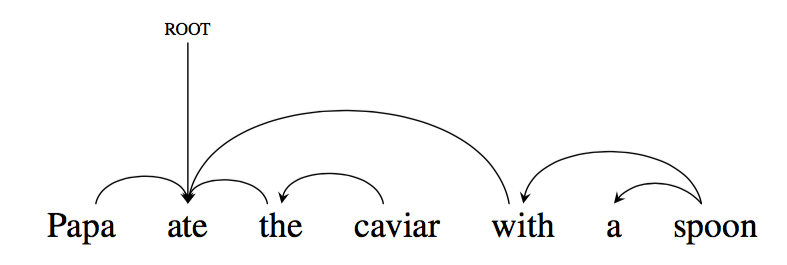

Formally, let a sentence $\mathbf{x}
\in \Sigma^*$, where $\Sigma$ is an alphabet, a finite non-empty set,
where we have augmented $\Sigma$ with a distinguished root symbol
*ROOT*. Given a sentence of length $|\mathbf{x}| = n$, a dependency parse of
$\mathbf{x}$ is a directed tree on
$(n+1)$ nodes, namely, the words of $\mathbf{x}$ and a new symbol ROOT, which is (you guessed it) the tree's root.

In this assignment, we will focus on *projective* dependency
parsing. Visually, a dependency parse is considered projective if,
drawing all the arcs above the sentence, it is the case that none of
them cross. The sentence above has a projective parse.
(The case of nonprojective parsing is interesting, full of weird heuristics and beautiful formalisms, and absolutely orthogonal to what this assignment is about.)
<!-- We refer the reader to [McDonald et al. (2005)](http://www.aclweb.org/anthology/H05-1066) for an example of an English sentence with a non-projective parse.
For a formal definition of projectivity, see [Nivre (2008)](https://www.mitpressjournals.org/doi/pdf/10.1162/coli.07-056-R1-07-027). -->


### Question 4.1

Before moving onto transition-based parsing, let's consider dependency parsing using an algorithm you already know.  There is a tight relationship between projective dependency parses and constituency parses. In this question, we ask that you design a dynamic-programming algorithm to parse dependency grammar.

We expect you to do this the following way: given an input sentence $\mathbf{x}$ of length $n$, design a sentence-specific *context-free grammar*, that, when provided to CKY, will yield trees that can trivially (i.e., in linear time) be transformed into dependency parses of $\mathbf{x}$. What is the runtime (in terms of $n$) of this algorithm?

**Answer:** $\color{red}{\text{FILL IN}}$

### Question 4.2

If you're on the right track, you will have found an answer that is $\omega(n^3)$, i.e., it will take at least cubic time, but may be worse. Can we do better? The algorithm in [Eisner 1996](http://cs.jhu.edu/~jason/papers/eisner.acl96.pdf) provides an elegant $O(n^3)$ solution.
Better explanations of the algorithm may be found in [Eisner 1997](https://cs.jhu.edu/~jason/papers/eisner.iwpt97.pdf) or [Eisner 2000](https://cs.jhu.edu/~jason/papers/eisner.iwptbook00.pdf).

Map the prose specification of the algorithm into pseudocode in a style similar to that used for CKY in the slides of 601.465. Argue that the runtime of this algorithm is, indeed, $O(n^3)$.

**Answer:** $\color{red}{\text{FILL IN}}$

Now, back to shift-reduce parsers. Shift-reduce parsers for
constituency trace their heritage back to fundamental work on
compilers in the 1960s; see Aho and Ullman (1972) for a
history. However, the modern shift-reduce parser for dependency
grammar is due to [Nivre (2003)](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.15.6213). Shift-reduce parsers rely on a transition
system, which we will take to be a quadruple $S = (C, T, c_s, C_t)$,
following [Nivre (2013)](http://stp.lingfil.uu.se/~nivre/master/transition.pdf).

* $C$ is a set of *configurations* (these will be our task/model states),
* $T$ is a set of transitions, each of which is a (partial) function $t: C \rightarrow C$,
* $c_s$ is an initialization function, mapping a sentence $\mathbf{x}$ to its initial configuration $c_s(\mathbf{x})$, 
* $C_t \subseteq C$ is a set of terminal configurations.

A configuration $c$ for a sentence $\mathbf{x}$ is a triple $c = \left(\sigma,
\beta, N \right)$, where $\sigma$ is termed the stack, $\beta$ the
buffer, and $N$ is a set of dependency arcs built so far. Note
that dependency arcs are represented as an ordered pair $(i, j)$ that
denotes a directed arc from the $i^\text{th}$ word in $\mathbf{x}$ towards
the $j^\text{th}$ word in $\mathbf{x}$. 

A myriad transition systems abound, with a veritable cottage industry
dedicated to the development of novel ones. In this work, we will
focus on the so-called *arc-standard* system, which consists
of the following definitions:


* **Initialization:** $c_s(\mathbf{x}) = ([0], [1, \ldots, n]), \emptyset)$
* **Terminal:** $C_t = \{c \in C :  c = ([0], [0], N)  \}$
* **Transitions:**
  * *Shift*: $(\sigma, [i \mid \beta], N) \Rightarrow ([\sigma \mid i], \beta, N)$ 
  * *ReduceLeft:* $([\sigma \mid i \mid j], \beta, N) \Rightarrow ([\sigma \mid j], \beta, N \cup \{(j, i)\})$ 
  * *ReduceRight:* $([\sigma \mid i \mid j], \beta, N) \Rightarrow ([\sigma \mid i], \beta, N \cup \{(i, j) \})$
  
We have represented the transitions using the standard notation found
in the dependency-parsing literature. To make it explicit, we will
clarify a few points. We write $c \Rightarrow c'$ to indicate that
configuration $c \in C$ transitions to the configuration $c' \in C$.
We write $[\sigma | i]$ to indicate a stack whose top element is $i$
and whose remaining elements are found in $\sigma$. Similarly, we write
$[i \mid \beta]$ to indicate a buffer whose first element is $i$ and the
remaining elements are $\beta$.

**Important:** To gain a solid intuition for how the arc-standard transition system works, we ask that you view the animation present in the following [slides](https://web.archive.org/web/20180712194612/http://demo.clab.cs.cmu.edu/fa2015-11711/images/b/b1/TbparsingSmallCorrection.pdf), due to [Miguel Ballesteros](http://miguelballesteros.com/).
That should also make it obvious why we chose this peculiar alignment for rendering them.

**Caveat:** Most dependency parsers also assign an arc label to the arc. We have omitted this for simplicity. 

You'll see that it is necessary to convert the desired dependency trees into action sequences before we can continue -- and the mapping is not as trivial as it was for the tagging case. Look at the following definition of the `ParsingTask` as a `StatefulTaskSetting`:

In [ ]:
class ParsingTask(StatefulTaskSetting):
    """
    xx = the sentence
    aa = the parse tree (represented as the id of the parent where 0 is root)
    yy = the shift/reduce actions that build the parse tree 
    """
    
    @staticmethod
    def convert_to_actions(tree):
        """
        Convert the depedency tree (sequence of parents) to the stack shift/reduce operations
        
        Returns a tuple representing the operations that convert this into a shift/reduce tree.
             0 == shift operation
             1 == reduce right
             2 == reduce left
        """
        stack = [(0, None)]
        i = 0
        # the stack actions that we have to perform
        operations = []
        while True:
            if len(stack) >= 2 and stack[-2][0] == stack[-1][1] and stack[-1][0] not in tree[i:]:
                # the top element of the stack is the child of the second on the top of the stack
                operations.append(2)  # left
                del stack[-1]
            elif len(stack) >= 2 and stack[-2][1] == stack[-1][0]:
                # the second element on the stack is the child of the item just added to the stack
                operations.append(1)  # right
                del stack[-2]
            else:
                # then we are going to perform a shift action
                if i >= len(tree):
                    break
                operations.append(0)  # shift
                id, parent = i + 1, tree[i]
                i += 1
                stack.append((id, parent))
        assert len(stack) == 1 and stack[0][0] == 0
        
        # return a list of shift and
        return tuple(operations)
    
    @staticmethod
    def convert_to_tree(actions):
        """
        Convert stack operations back to the depedency tree
        """
        l = actions.count(0)  # count the number of words
        assert l * 2 == len(actions)  # There should be exactly twice as many operations as words
        parents = [-1] * l  # the list of parents

        stack = [-1]
        i = 0
        for y in actions:
            if y == 0:
                # perform a shift operation by adding to the stack word i
                stack.append(i)
                i += 1
            elif y == 1:
                # perform shift right by marking the parent of the second element on the stack
                # and removing it from the stack
                parents[stack[-2]] = stack[-1] + 1
                del stack[-2]
            else:
                # perform shift left
                parents[stack[-1]] = stack[-2] + 1
                del stack[-1]

        assert len(stack) == 1, "stack should only have the root element when it is done, otherwise this is invalid"
        
        return tuple(parents)
    
    @staticmethod
    def iterate_data(*args, **kwargs):
        """
        Iterate through our parse data, converting the trees into a series of
        shift/reduce actions for `yy` that we can train and test on
        """
        for example in iterate_trees(*args, **kwargs):
            yield Data_type(
                xx=example.xx,
                oo=None,  # We are not dealing with partial observations in this homework
                yy=ParsingTask.convert_to_actions(example.tree)
            )
    
    
    def initial_taskstate(self, *, xx):
        """
        The initial state for an input `xx` is a stack that only contains the ROOT symbol
        and a buffer with the entire sentence on it.
        """
        (stacksize, buffersize) = 1, len(xx)
        return (stacksize, buffersize)
        
    def next_taskstate(self, *, xx, a, taskstate):
        """
        Increases/decreases sizes according to action `a` taken.
        """
        (stacksize, buffersize) = taskstate
        if a == 0:  #shift
            return (stacksize + 1, buffersize - 1)
        elif a in (1, 2):  # reduce
            return (stacksize - 1, buffersize)
        else:
            assert a is None
            return None

    def iterate_a(self, *, xx, oo=None, taskstate):
        """        
        Remember that this method ought to yield `None` (as one possible "action")
        when the given `taskstate` permits stopping.
        """
        stacksize, buffersize = taskstate
        
        if buffersize > 0:
            # there are still tokens that this can process
            # yield a shift operation
            yield 0  # shift operation
        if stacksize > 2:
            # these are the shift operations that we are allowed to perform
            # if one of these are valid then both of these will valid
            yield 1  # right
            yield 2  # left
        if stacksize == 2 and buffersize == 0:
            # Only ROOT and the "actual" root word left on the stack: finish
            yield 2

    def iterate_a_s(self, *, xx, oo=None, taskstate):
        for a in self.iterate_a(xx=xx, taskstate=taskstate):
            yield a, self.next_taskstate(xx=xx, a=a, taskstate=taskstate)

    def reward(self, *, aa, xx, yy):
        """
        The proxy reward of prediction aa on this sentence if the true chunking is yy.
        """
        tree_gen = self.convert_to_tree(yy=aa)
        tree_gold = self.convert_to_tree(yy=yy)
        
        true_pos = sum(a == b for a,b in zip(tree_gen, tree_gold))
        
        exact = int(tree_gen == tree_gold)
        return true_pos

    def reward_F1_triple(self, *, aa, xx, yy):
        """
        returns a triple (true_pos, true, pos) used to compute corpus-level F1:
           `true_pos` is the number of "true positives" (chunks reported by `aa` that are truly in `yy`)
           `true` is the number of chunks that are truly in `yy`  
           `pos` is the number of chunks reported by `aa`
        """
        # aa is the predicted output
        # yy is the gold label from the dataset
        # both have already been converted to the shift/reduce operations
        # so we have to convert it back into a tree which lists the parents
        tree_gen = self.convert_to_tree(aa)
        tree_gold = self.convert_to_tree(yy)
        
        true_pos = sum(a == b for a,b in zip(tree_gen, tree_gold))
        return np.array([len(tree_gold), len(tree_gen), true_pos])

    
parsing_task = ParsingTask()

Please study the following output carefully, to gain an intuition for why the above code converts
dependency parses into sequences of shift and reduce actions. 

In [ ]:
print(ParsingTask.convert_to_actions(tree=(0, 1, 1, 1, 7, 7, 1)))
print(ParsingTask.convert_to_tree(actions=(0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 1, 1, 2, 2)))

for tree in set(p.tree for p in iterate_trees('train')):
    actions = ParsingTask.convert_to_actions(tree)
    tree2 = ParsingTask.convert_to_tree(actions)
    assert tree == tree2
    assert len(actions) == len(tree)*2  # there will always be twice as many shift/reduce operations

### Question 4.3

Why is `ParsingTask` a stateful task? Why is the task state necessary?

Answer: $\color{red}{\text{FILL IN}}$

## A neural parsing model

Now for the final bit of coding: you will implement the `score_a_s` method of the `ParsingModel` we defined below -- you'll see that it is very similar to the IOB model we defined above: we again have a "lookahead" LSTM (corresponding to the buffer for our transition-based system), a forward-LSTM of sorts (that now branches though, so that you will have to figure out), and scoring of actions to take in certain task and model states.

The network components have been initialized for you in `initialize_params()` -- `*_network_1` and `*_network_2` are to be stacked together to create a deeper network and the rest... you'll figure it out!
You may want to look at [Dyer et al. (2015)](https://arxiv.org/abs/1505.08075) to see how to perform the transition system actions with LSTMs; their figures will give you a rough idea of what the entire enterprise should look like (note though, that our model is a lot simpler! We for example omit the LSTM for the action sequence that they render in the lower middle of Figure 2).

In [ ]:
class ParsingModel(IncrementalScoringModel, nn.Module):
    
    def __init__(self, task, preprocessor):
        # Always initialize the PyTorch module first, so the registration hooks work!
        nn.Module.__init__(self)
        super().__init__(task)
        self.preprocessor = preprocessor

    def initialize_params(self):
        self.backward_lstm = nn.LSTMCell(HIDDEN_SIZE, HIDDEN_SIZE)
        self.forward_lstm = nn.LSTMCell(HIDDEN_SIZE, HIDDEN_SIZE)
        
        # judge two hidden-state-sized vectors and a (one-hot) action
        self.action_network_1 = nn.Linear(HIDDEN_SIZE*2+3, HIDDEN_SIZE)
        self.action_network_2 = nn.Linear(HIDDEN_SIZE, 1)
        
        # network for combining two elements on the stack to make a new representation for this tree
        self.combine_network_1 = nn.Linear(HIDDEN_SIZE*2, HIDDEN_SIZE*2)
        self.combine_network_2 = nn.Linear(HIDDEN_SIZE*2, HIDDEN_SIZE)
        
        self.lstm_init_backwards = nn.Parameter(torch.rand(1, HIDDEN_SIZE))
        self.lstm_init_forwards = nn.Parameter(torch.rand(1, HIDDEN_SIZE))
        
        self.stack_root = nn.Parameter(torch.rand(1, HIDDEN_SIZE))
    
    def initial_modelstate(self, *, xx):
        """
        xx is going to be the result of the first encoding pass
        and then we want to run the backwards LSTM over this xx sequence
        """
        # Run the preprocessor to generate a representation for each token in the input xx
        xx_embedding = self.preprocessor(xx=xx)
        
        # this will represent the backwards LSTM over the words that are in the sentence
        buffer = []
        
        cx = self.lstm_init_backwards
        hx = torch.tanh(cx)
        buffer.append(hx)
        for i in range(xx_embedding.shape[1]-1,-1,-1):
            hx, cx = self.backward_lstm(xx_embedding[:,i], (hx, cx))
            buffer.append(hx)
        cx = self.lstm_init_forwards
        hx = torch.tanh(cx)
        # the pre root element on the stack
        stack = [
            (cx, hx, None),  # the -1 element doesn't need an embedding as this will 
        ]
        
        # push the root stack element
        hx, cx = self.forward_lstm(self.stack_root, (hx, cx))
        stack.append((cx, hx, self.stack_root))
        
        # return a tuple
        return xx_embedding, stack, buffer

    def score_a_s(self, *, xx, a, taskstate, modelstate):
        ### STUDENTS START
        raise NotImplementedError()  # REPLACE ME
        ### STUDENTS END
        # return score and new modelstate
        assert score.dim() == 0, f"Score {score} has shape {score.shape}, but should be {torch.tensor(0.0).shape}"
        return score, (xx_embedding, stack, buffer)

Let's try to train this model with our two different (non-broken) agents:

In [ ]:
english_character_integerizer = Integerizer(tuple(set(w for d in iterate_trees('train') for w in ' '.join(d.xx))))

parsing_model = ParsingModel(parsing_task,
                             CharacterLSTMPreprocessModule(english_character_integerizer))

greedy_parser = LocallyNormalizedGreedyDecisionAgent(parsing_model)

greedy_trainer = PyTorchTrainer(
    greedy_parser, 
    epochs=3, 
    evaluate=lambda x: x.test_F1(parsing_task.iterate_data('dev')))

%time greedy_trainer.train(parsing_task.iterate_data('train'))

In [ ]:
beam_parser = BeamDecisionAgent(parsing_model, beam_size=15)

beam_trainer = PyTorchTrainer(
    beam_parser,
    epochs=3, 
    evaluate=lambda x: x.test_F1(parsing_task.iterate_data('dev')))
    
%time beam_trainer.train(islice(parsing_task.iterate_data('train'), 2000))

## Speedups not covered in this assignment

1. In making a neural model that you actually want to work with, you would probably want to spend some time thinking about how to perform mini-batching.  One of the main reasons that this will speed up our program, is that we are currently performing matrix-vector operations in most cases, in that there is only a single sentence that we are processing at a time.  When mini-batching, you are able to process more than once sentence at a time, this allows for using matrix-matrix operations which will be must faster.  Additionally, less time will be spent on the overhead of PyTorch/Python per sentence we are processing.  Making good use of a GPU will generally require that there are larger matrix-matrix operations which are being performed.

2. Given that this network is *dynamically structured* based off the input of the yy sequence, it can sometimes be difficult to identify a good way to mini-batch multiple sentences at the same time.  An alternate approach is to distribute computation between a number of works that are each processing a single sentence at a time.  This allows us to take advantage of the fact that the sentences themselves are independent from each other while still being able to utilize resources.  [Pytorch multiprocessing documentation](http://pytorch.org/docs/master/notes/multiprocessing.html)

3. You could also try changing the `num_threads` at the top of this notebook to experiment with the number of threads that are used for [BLAS](http://www.netlib.org/blas/) operations.  BLAS is the library that backs all of the matrix operations that you perform in virtually every other library or language (including R, numpy or matlab).  Assuming that you have *sufficiently large* matrices and have enough CPUs cores on your computer, increasing the number of threads that you are using can improve the runtime.


If you want to try to improve the performance of the parser that we built in this notebook, you can try increasing the `HIDDEN_SIZE` that is used throughout.  We set it to 30 by default, but if you set it to larger value like 300, you should expect to see a significant improvement.  Note that the runtime performance scales $O(\texttt{HIDDEN_SIZE}^2)$ so changing the value to 300 will make it take 100 times longer to train assuming that you don't apply any other techniques to speedup your model.

# The final test !!!

Now that you have completed the assignment with the development datasets, try your models on the test dataset for 1 final time.

In [ ]:
### STUDENTS START
### iob_agent = ???
raise NotImplementedError()  # REPLACE ME
### STUDENTS END

iob_agent.test_F1(iterate_data('test'))

In [ ]:
### STUDENTS START
### parse_agent = ???
raise NotImplementedError()  # REPLACE ME
### STUDENTS END

parse_agent.test_F1(parsing_task.iterate_data('test'))